In [118]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.simulation import run_test, SimulationHistory
from viz import plot_trajectory_in_tank

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(2)

## Parameters

In [8]:
agent_speed = 4 # cm/s
dt = 0.5 # s
multiplier = agent_speed * dt
actual_tank_size = np.array([90,114]) # actual size: 90cm x 114cm but it is scaled by a walking speed of <multiplier>
tank_size = (actual_tank_size / multiplier).astype(int)
space_shape = (tank_size * 2) + 1

goal_radius = 1
# odor_radius = 10.5
odor_radius = 3 / multiplier # 3 cm * 0.8 -> 3.75 grid units

In [9]:
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - tank_size[None,:])**2, axis=1) <= (odor_radius ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

## Building model

In [10]:
env = Environment(data_file=odor_field[None,:,:],
                  data_source_position=tank_size,
                  source_radius=goal_radius,
                  boundary_condition='wrap')

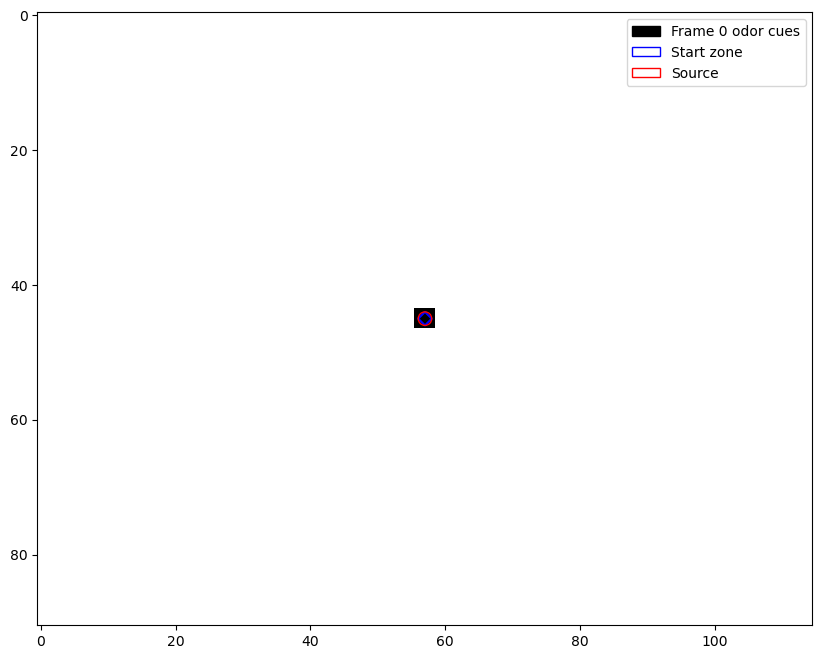

In [11]:
_,ax = plt.subplots(1,1, figsize=(10,10))
env.plot(ax=ax)

## Agent Training

In [12]:
ag = FSVI_Agent(env)

In [13]:
_ = ag.train(expansions=800,
             max_belief_growth=100,
             eps=1e-8,
             use_gpu=True)

[12/10/2024, 12:42:55] MDP_policy, not provided. Solving MDP with Value Iteration...
[12/10/2024, 12:42:55] Sending Model to GPU...
[12/10/2024, 12:42:55]     > Done in 0.270s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 10465-state, 4-action
  - Converged in 1000 iterations and 0.7150 seconds
  - Took on average 0.0007s per iteration


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 10465 state, 4 action, 3 observations
  - Converged or stopped after 800 expansion steps and 800 backup steps.
  - Resulting value function has 8954 alpha vectors.
  - Converged in 223.2792s

  - Expand function took on average 0.0634s and yielded on average 6247.60 beliefs per iteration. (0.0000s/it/belief)
  - Backup function took on average 0.2157s and yielded on average 11.19 alpha vectors per iteration. (0.0003s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


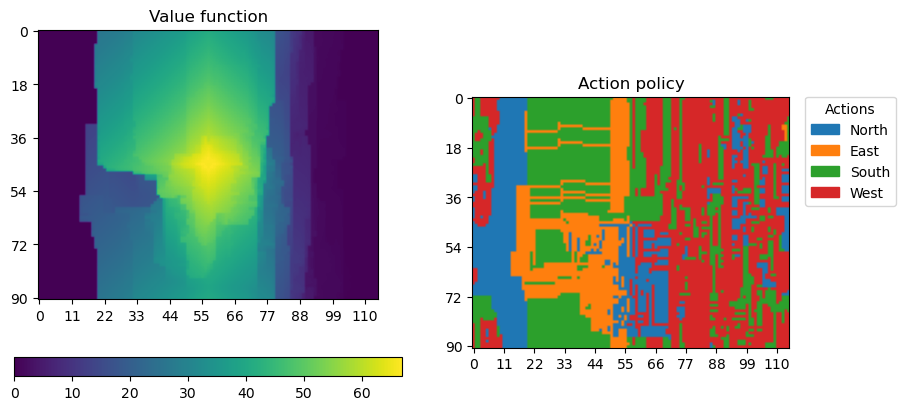

In [14]:
ag.value_function.plot()

## Run test

### Single point

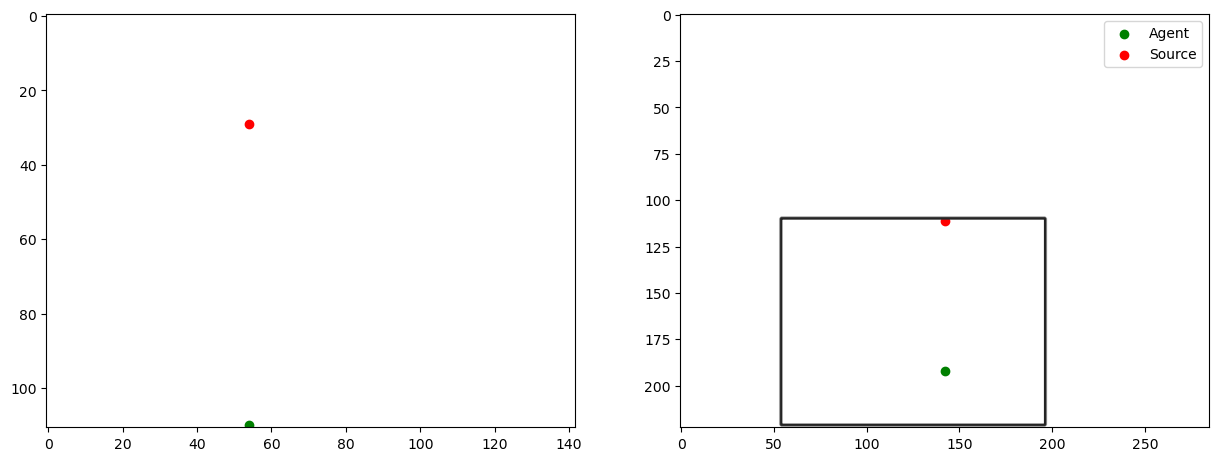

In [10]:
# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(space_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(space_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [11]:
belief = BeliefSet(model=ag.model, beliefs=[Belief(model=ag.model, values=belief.ravel())])
hist = run_test(agent=ag,
                start_points=agent_start_state[None,:],
                initialization_values={'belief': belief},
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 8.684s:
Simulations reached goal: 0/1 (1 failures (reached horizon: 1)) (0.00% success)


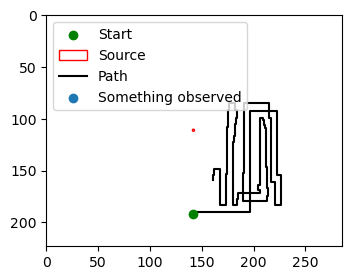

In [12]:
hist.plot()

### Multipoint

In [17]:
all_indices = np.array(list(np.ndindex((5,3))))
all_indices = (all_indices * 20) + np.array([15,90])

source_indices = np.array(list(np.ndindex((5,3))))
source_indices = (source_indices * 20) + np.array([15,20])

In [18]:
all_source_pos = np.repeat(source_indices, [len(all_indices)]*len(source_indices), axis=0)
all_agent_start = np.tile(all_indices, reps=(len(source_indices),1))

In [19]:
# Generation of points
n = len(source_indices) * len(all_indices)

# STATE SPACE
center_state = all_agent_start
agent_start_state = center_state + (tank_size[None,:] - all_source_pos)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(space_shape)
    belief[center[0]:center[0]+tank_size[0]+1, center[1]:center[1]+tank_size[1]+1] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

In [20]:
belief = BeliefSet(ag.model, beliefs)
hist = run_test(agent=ag,
                n=n,
                start_points=agent_start_state,
                initialization_values={'belief': belief},
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 16.924s:
Simulations reached goal: 0/225 (225 failures (reached horizon: 225)) (0.00% success)


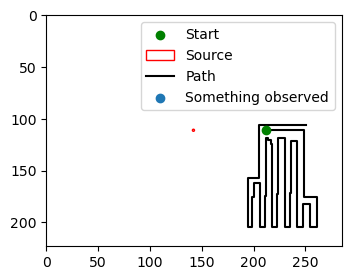

In [21]:
hist.plot()

In [ ]:
# hist.save()

Simulations saved to: ./Simulations-s_223_285-n_225-20241113_175053-horizon_1000.csv
Simulation's analysis saved to: ./Simulations-s_223_285-n_225-20241113_175053-horizon_1000-analysis.csv


### Experimental data

In [15]:
df = pd.read_csv('../experimental_data/experimental_positions.csv')

In [16]:
exp_source_indices = df[['y_food_cm','x_food_cm']].to_numpy().astype(float)
exp_agent_indices = df[['y0_cm', 'x0_cm']].to_numpy().astype(float)

exp_source_indices /= multiplier
exp_agent_indices /= multiplier

exp_source_indices = exp_source_indices.astype(int)
exp_agent_indices = exp_agent_indices.astype(int)

In [17]:
# Generation of points
n = len(exp_source_indices)

# STATE SPACE
center_state = exp_agent_indices
agent_start_state = center_state + (tank_size[None,:] - exp_source_indices)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(space_shape)
    belief[center[0]:center[0]+tank_size[0]+1, center[1]:center[1]+tank_size[1]+1] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

In [18]:
belief = BeliefSet(ag.model, beliefs)
hist = run_test(agent=ag,
                n=n,
                start_points=agent_start_state,
                initialization_values={'belief': belief},
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 4.349s:
Simulations reached goal: 105/118 (13 failures (reached horizon: 13)) (88.98% success)
 - Average step count:                 416.339 +- 291.50 (Successful only: 344.076 +- 220.35)
 - Extra steps:                        386.068 +- 291.44 (Successful only: 314.152 +- 221.27)
 - Average discounted rewards (ADR):   0.106 +- 0.18 (Successful only: 0.119 +- 0.19)
 - Tmin/T:                             0.141 +- 0.18 (Successful only: 0.155 +- 0.19)


In [ ]:
# hist.save()

Simulations saved to: ./Simulations-s_91_115-n_118-20241210_124836-horizon_1000.csv
Simulation's analysis saved to: ./Simulations-s_91_115-n_118-20241210_124836-horizon_1000-analysis.csv


## Plot results

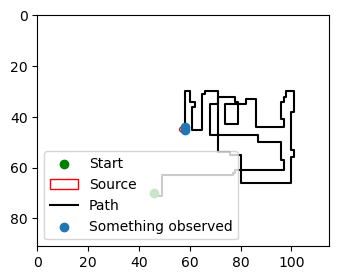

In [20]:
hist.plot()

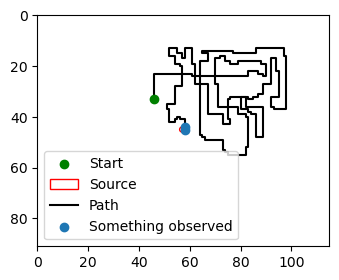

In [21]:
hist.plot(2)

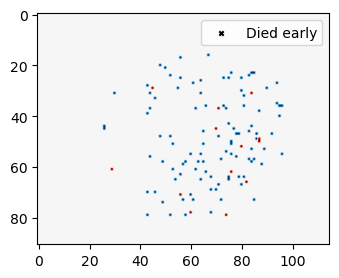

In [19]:
hist.plot_successes()

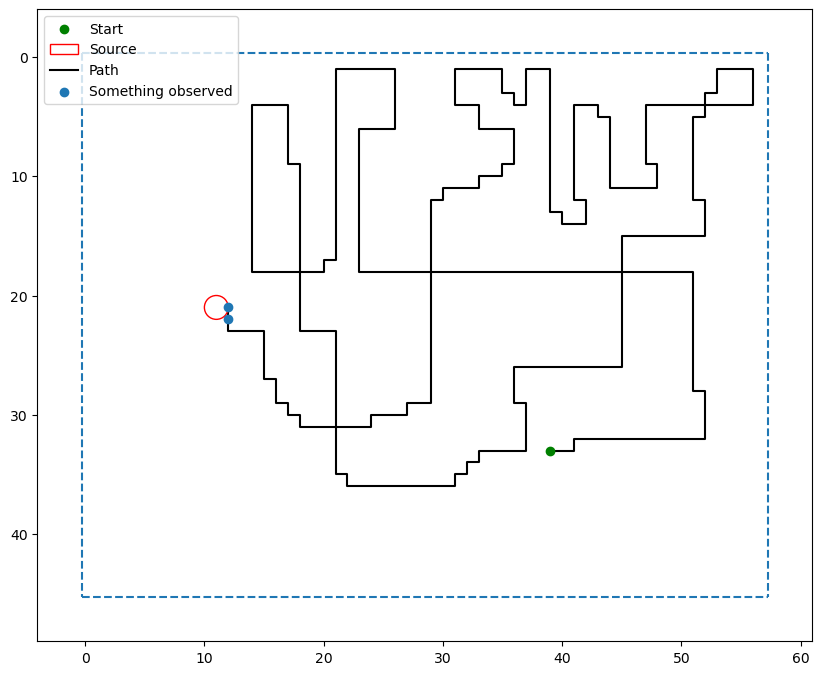

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h=hist, exp_agent=exp_agent_indices, exp_source=exp_source_indices, t_size=tank_size, traj=110, ax=ax)

In [62]:
a_df = hist.analysis_df

In [67]:
runs_df = a_df[[str(i).startswith('run_') for i in a_df.index]]

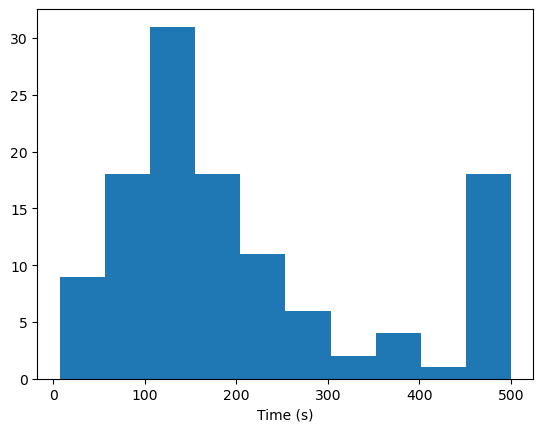

In [77]:
ax = (runs_df['steps_taken'] * dt).hist(grid=False)
ax.set_xlabel('Time (s)')
plt.show()

In [112]:
successes = np.array(runs_df['converged'])
speed = np.array(runs_df['steps_taken'])
# speed = np.array(runs_df['t_min_over_t'])

In [119]:
point_array = exp_source_indices # exp_agent_indices or exp_source_indices

grid = np.array([5,8])
cell_indices = np.array(list(np.ndindex(tuple(grid))))
cell_sizes = tank_size / grid

point_cell = (point_array / cell_sizes).astype(int)

In [127]:
point_cell

array([[1, 1],
       [3, 1],
       [3, 2],
       [2, 2],
       [1, 2],
       [3, 2],
       [2, 2],
       [1, 1],
       [3, 2],
       [2, 2],
       [2, 2],
       [3, 2],
       [3, 2],
       [2, 2],
       [2, 2],
       [3, 2],
       [3, 2],
       [1, 2],
       [2, 2],
       [3, 2],
       [2, 2],
       [3, 2],
       [2, 3],
       [3, 4],
       [1, 4],
       [1, 2],
       [2, 2],
       [1, 2],
       [2, 2],
       [2, 5],
       [3, 5],
       [2, 5],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 1],
       [3, 1],
       [3, 1],
       [3, 1],
       [3, 1],
       [3, 0],
       [3, 0],
       [3, 0],
       [3, 0],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [3, 4],
       [3,

In [129]:
success_array = np.empty(grid, dtype=float)
speed_array = np.empty(grid, dtype=float)
count_array = np.empty(grid, dtype=float)

for cell in cell_indices:
    point_in_cell = np.all(point_cell == cell, axis=1)
    count_in_cell = np.sum(point_in_cell)
    if count_in_cell == 0:
        continue

    success_perc = np.mean(successes[point_in_cell])
    average_speed = np.mean(speed[point_in_cell])

    success_array[*cell] = success_perc
    speed_array[*cell] = average_speed
    count_array[*cell] = count_in_cell

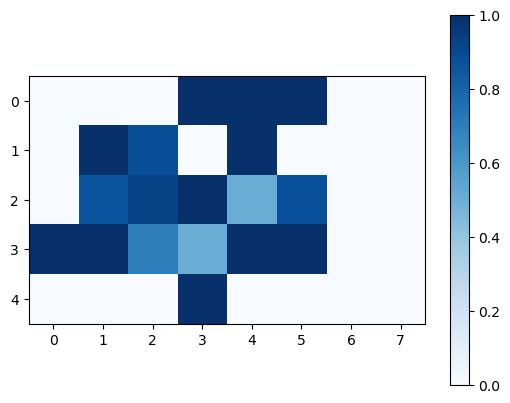

In [131]:
plt.imshow(success_array, cmap='Blues')
plt.colorbar()
plt.show()

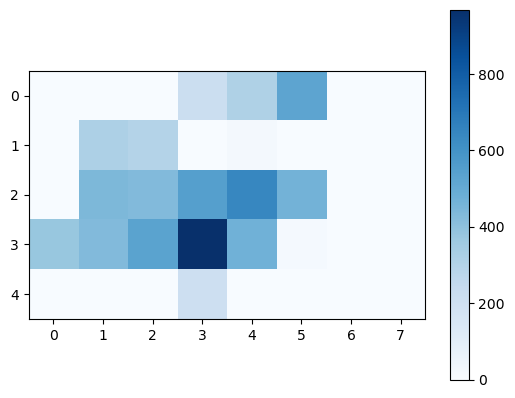

In [132]:
plt.imshow(speed_array, cmap='Blues')
plt.colorbar()
plt.show()